# Visualization

This is a visualization of our project.

In [34]:
# import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter
from torchvision.utils import make_grid
%matplotlib inline

# import custom libaries
from parameters_settings import *
from my_lib import *

# Settings of Styles
sns.set_palette('pastel')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 18

## 1. Dataset Visualization

In [1]:
# Load dataset
train_set, class_names = load_dataset("./data/merged_train.pt")
test_set, class_names = load_dataset("./data/merged_test.pt")

# Display basic information
print("="*50)
print(f"- Length of Train Set: {len(train_set)}")
print(f"- Length of Test Set: {len(test_set)}")
print(f"- Number of Classes: {len(class_names)}")
print(f"- Shape of the Images: {train_set[0][0].shape}")

# Display a dataframe
train_counts = Counter()
for _, label in train_set:
    train_counts[label.item()] += 1

test_counts = Counter()
for _, label in train_set:
    test_counts[label.item()] += 1

dist_df = pd.DataFrame({
    'Classes': class_names,
    'Num of Train Set': [train_counts[i] for i in range(len(class_names))],
    'Num of Test Set': [test_counts[i] for i in range(len(class_names))]
})

dist_df['Percentage of Train Set'] = dist_df['Num of Train Set'] / len(train_set) * 100
dist_df['Percentage of Test Set'] = dist_df['Num of Test Set'] / len(train_set) * 100

display(dist_df.style.background_gradient(
    subset=['Num of Train Set', 'Num of Test Set'],
    cmap='Blues').format({
        'Percentage of Train Set': '{:.1f}%',
        'Percentage of Test Set': '{:.1f}%'
    }))

- Length of Train Set: 67557
- Length of Test Set: 11010
- Number of Classes: 16
- Shape of the Images: torch.Size([1, 28, 28])


,Classes,Num of Train Set,Num of Test Set,Percentage of Train Set,Percentage of Test Set
0,0,6349,6349,9.4%,9.4%
1,1,7174,7174,10.6%,10.6%
2,2,6388,6388,9.5%,9.5%
3,3,6560,6560,9.7%,9.7%
4,4,6273,6273,9.3%,9.3%
5,5,5852,5852,8.7%,8.7%
6,6,6347,6347,9.4%,9.4%
7,7,6695,6695,9.9%,9.9%
8,8,6280,6280,9.3%,9.3%
9,9,6379,6379,9.4%,9.4%


In [2]:
# TODO: display some example images of dataset

## 2. Single Character Recognition Result

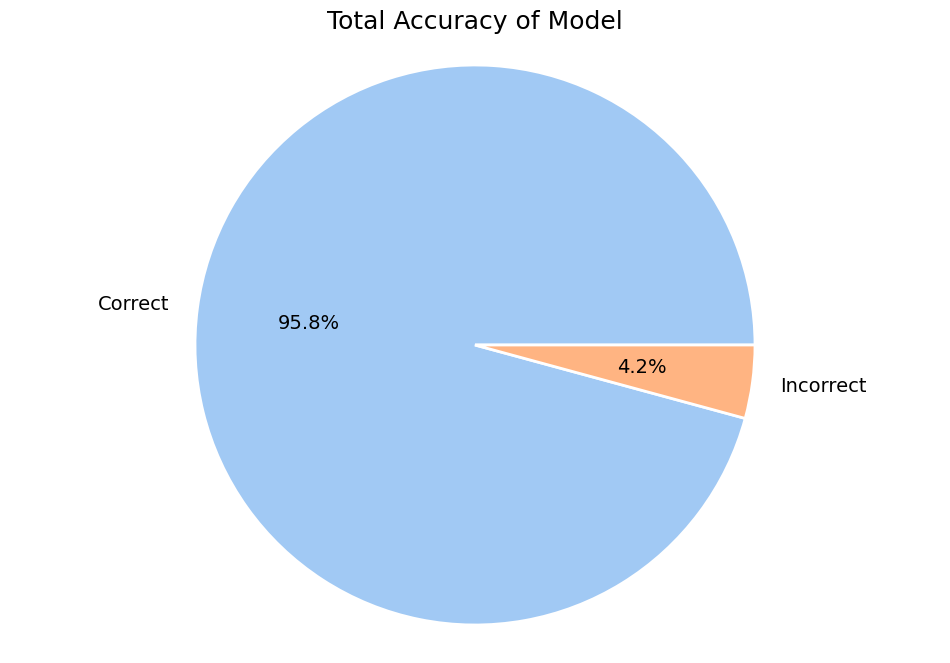

In [17]:
from rcg_single_char import Net

# Load model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(len(class_names)).to(device)
model.load_state_dict( torch.load('model.pth', map_location=device) )

# Load test data
test_images, test_labels = test_set.images, test_set.labels

# Evaluate the model
def evaluate_model(model, images, labels, batch_size=4):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for i in range(0, len(images), batch_size):
            batch_imgs = images[i: i+batch_size].to(device)
            outputs = model(batch_imgs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels[i: i+batch_size].numpy())
    return np.array(all_labels), np.array(all_preds)

true_labels, pre_labels = evaluate_model(model, test_images, test_labels)
acc = np.mean(true_labels==pre_labels)

# plot the result
plt.pie([acc, 1-acc], labels=['Correct', 'Incorrect'],
        autopct='%1.1f%%', startangle=0, 
        wedgeprops={'linewidth':2, 'edgecolor':'w'})
plt.title('Total Accuracy of Model')
plt.axis('equal')
plt.show()

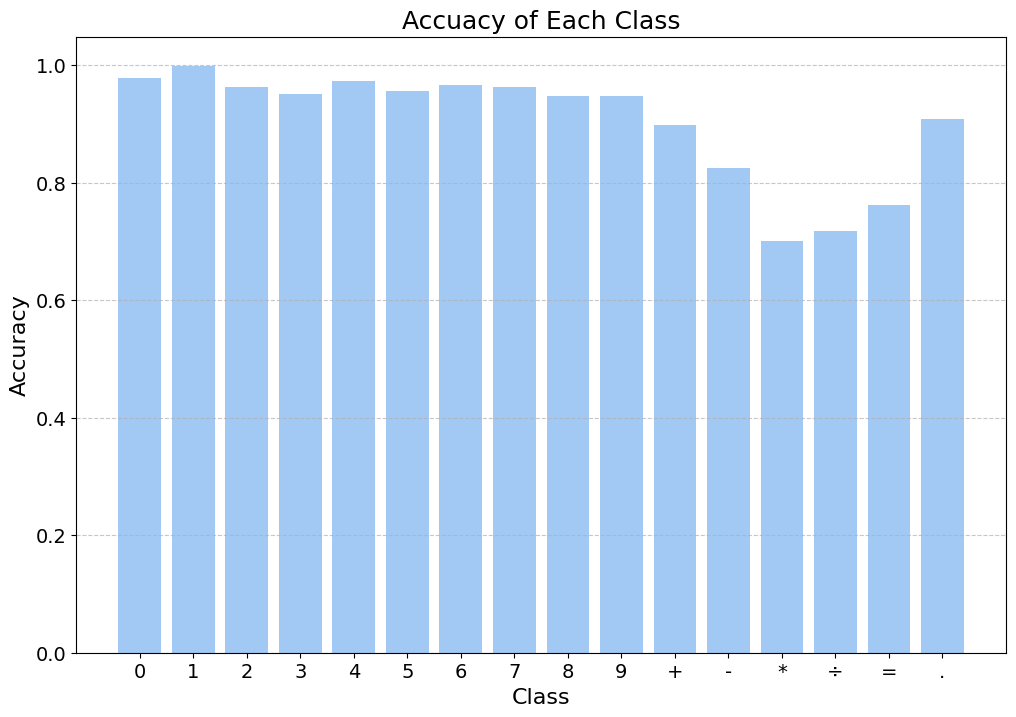

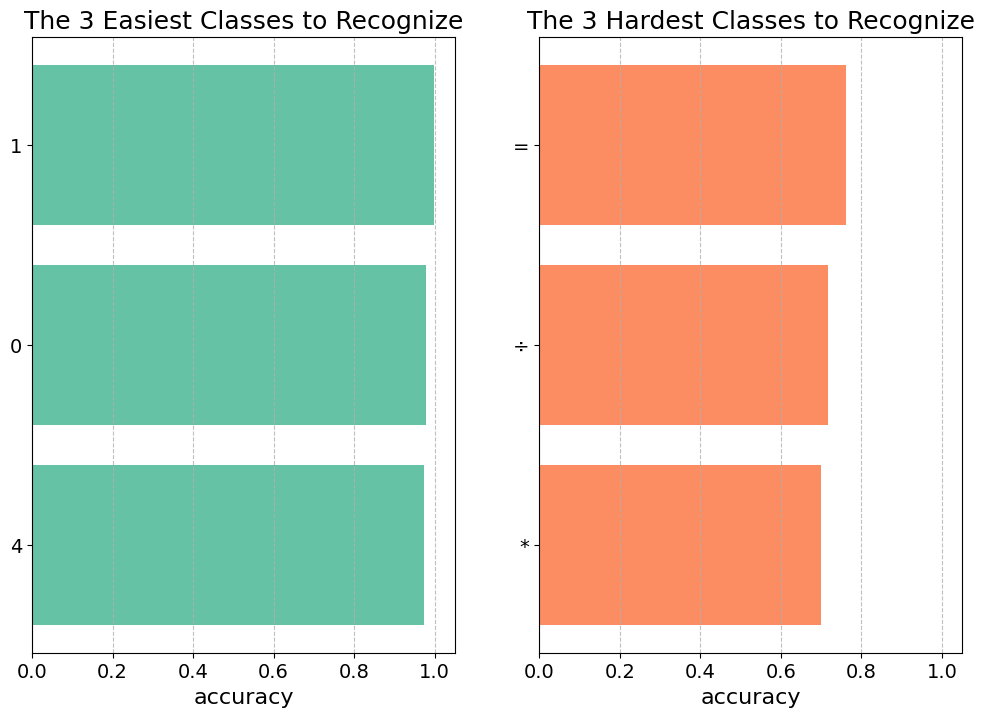

In [34]:
# Accuracy by classes

class_acc = []
for i in range(len(class_names)):
    mask = true_labels==i
    if mask.sum() > 0:
        acc = np.mean(pre_labels[mask]==i)
    else:
        acc = 0
    class_acc.append(acc)

# Plot the result
plt.bar(class_names, class_acc)
plt.title("Accuacy of Each Class")
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Sort the accuracy
sorted_class = sorted(zip(class_names, class_acc), key=lambda x: x[1])
easiest = sorted_class[-3:]
hardest = sorted_class[:3]

# Plot easiest
plt.subplot(1, 2, 1)
plt.barh([x[0] for x in easiest], [x[1] for x in easiest], color='#66c2a5')
plt.title('The 3 Easiest Classes to Recognize')
plt.xlabel('accuracy')
plt.xlim(0, 1.05)
plt.grid(axis='x', linestyle='--', alpha=0.8)

# Plot hardest
plt.subplot(122)
plt.barh([x[0] for x in hardest], [x[1] for x in hardest], color='#fc8d62')
plt.title('The 3 Hardest Classes to Recognize')
plt.xlabel('accuracy')
plt.xlim(0, 1.05)
plt.grid(axis='x', linestyle='--', alpha=0.8)

plt.show()


### 2.3: Analyze Incorrect Recognition Examples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3438569..2.2870297].


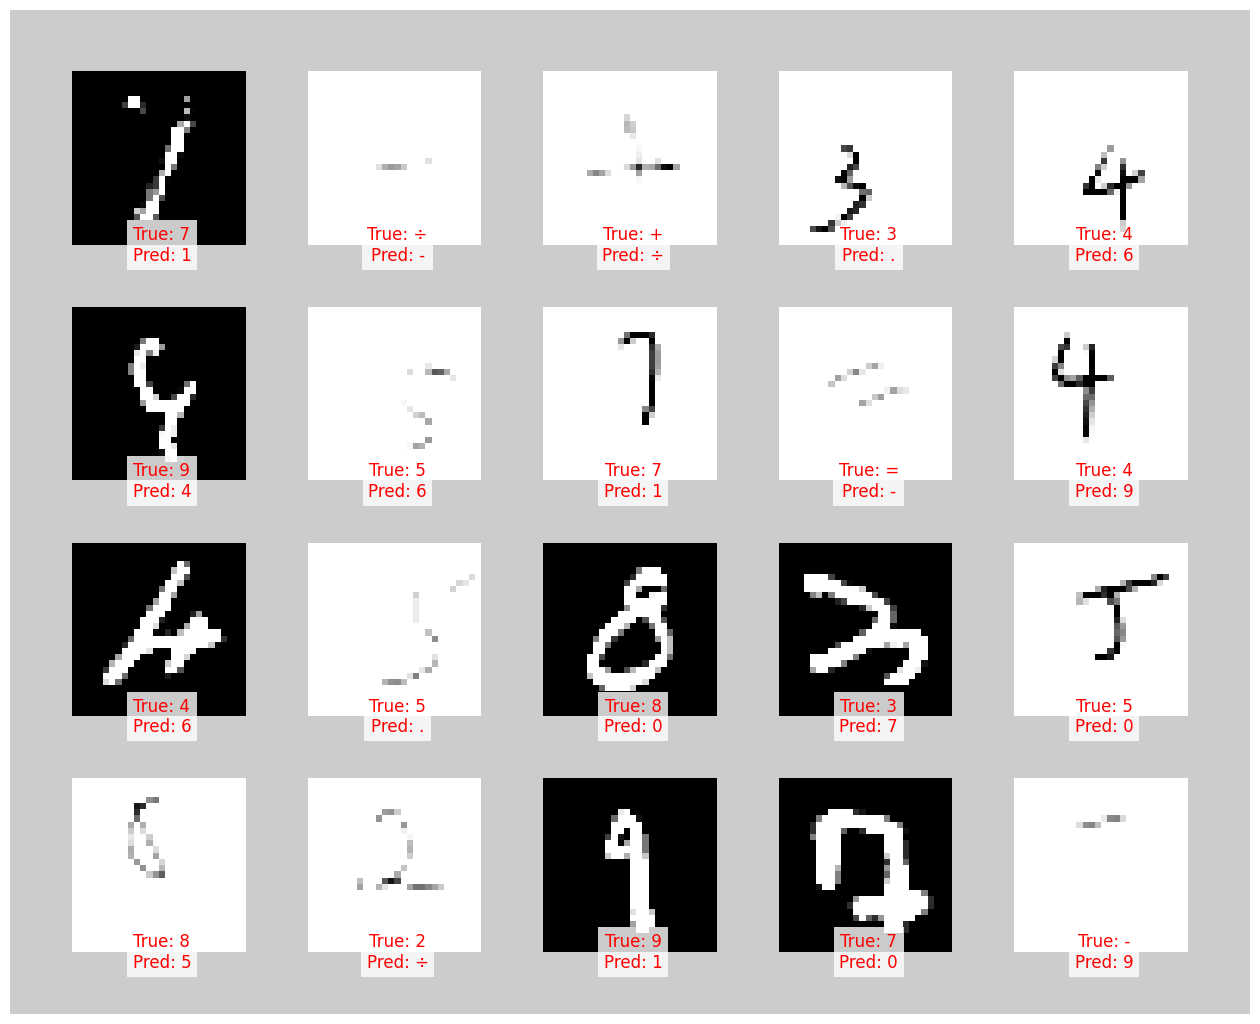

In [ ]:
def visualize_errors(true_labels, pre_labels, images, class_names, n_errors=20):
    error_indices = np.where(true_labels != pre_labels)[0]
    if len(error_indices)==0:
        print("Congratulations! There isn't any errors at all!!! > v <")
        return
    selected_errors = np.random.choice(error_indices, min(n_errors, len(error_indices)), replace=False)
    
    err_imgs, captions = [] , []
    for idx in selected_errors:
        img = images[idx]
        true_class = class_names[true_labels[idx]]
        pred_class = class_names[pre_labels[idx]]
        err_imgs.append(img)
        captions.append(f"True: {true_class}\nPred: {pred_class}")
    grid = make_grid(err_imgs, nrow=5, padding=10, pad_value=0.8)
    plt.figure(figsize=(16, min(4 * (len(selected_errors)//5 + 1), 20)))
    plt.imshow(grid.permute(1, 2, 0) if grid.shape[0]==3 else grid[0])
    
    # Add captions
    for i, idx in enumerate(selected_errors):
        row, col = i // 5, i % 5
        plt.text(col*38+24, row*38+40, captions[i],
                 color='red', fontsize=12, ha='center',
                 bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
    
    plt.axis('off')
    plt.show()

visualize_errors(true_labels, pre_labels, test_images, class_names)